# Conditional Score-based Diffusion Models for Time Series Imputation

This notebook investigates the application of Conditional Score-based Diffusion Models (CSDI) to time series imputation. Developed by researchers at Stanford University, CSDI adapts diffusion model principles, primarily used in image and audio synthesis, to effectively handle missing data in time series. Conditional Score-based Diffusion models for Imputation (CSDI) is a novel approach for imputing missing values in time series data by leveraging the power of score-based diffusion models. These models have shown remarkable success in various generative tasks, such as image and audio synthesis, and are now adapted for time series imputation.

## Background
Time series data, especially in healthcare and finance, often contain gaps resulting from sensor failures or incomplete data capture. Traditional imputation methods typically overlook the complex temporal dependencies inherent in time series data. CSDI addresses these challenges by using a conditional diffusion process to impute missing values, leveraging observed data to guide the imputation process.

## Objectives
- Introduce the theoretical framework and operation of CSDI.
- Implement the CSDI model using PyTorch to showcase its application on real-world datasets.
- Assess CSDI's performance in imputing missing values compared to conventional imputation techniques.

Through the exploration of CSDI's implementation and its imputation efficacy, this notebook aims to highlight its potential in improving the accuracy and reliability of time series analysis.

## Library Imports and Model Setup

In this section, we import necessary libraries and modules required for the implementation of the CSDI model. This includes standard data handling libraries like `numpy` and `pandas`, deep learning libraries from `torch`, and specific components for building and training the CSDI model.

In [2]:
import os
import sys
import torch
import torch.nn as nn
import yaml
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import wget
import datetime
import seaborn as sns
import pickle
import pandas as pd

# Add the parent directory to sys.path to import local modules
sys.path.append(os.path.abspath(os.path.join("..")))

# from main_model import CSDI_Physio
from dataset.dataset_physio import get_dataloader
from util.utils import train, evaluate
from diff_models import diff_CSDI

## Time Series Imputation with the PhysioNet 2012 Challenge Dataset 

The 2012 PhysioNet Challenge dataset is often used for exploring methods in handling missing data in multivariate medical time series, a critical issue in ICU data management. 

### Data Description

This dataset contains multivariate time series data from ICU admissions, anonymized and sampled from a broader database. Each patient's record includes various physiological measurements, lab results, and vital signs, recorded at different timestamps during the first 48 hours of ICU admission.

### Features

- **Vital Signs:** Includes irregularly recorded data on heart rate, blood pressure, respiration rate, and temperature.
- **Lab Results:** Blood tests such as blood chemistry, complete blood counts, and arterial blood gases, noted at various intervals.
- **Time Stamps:** Data entries are timestamped, highlighting the irregular time intervals at which they were recorded.

Let's get started by loading and exploring the dataset!

## Download Dataset

Run this cell to download the physio dataset if you haven't already.

In [3]:
def download_physio_data():
    """
    Checks if the PhysioNet Challenge 2012 dataset is already downloaded and extracted.
    If not present, it downloads and extracts the dataset. You can change the download path
    or save location by modifying the 'data/' directory path in the code.
    """
    # Path to the dataset directory and the tar file
    data_dir = "data/"
    dataset_tar_path = "data/set-a.tar.gz"
    extracted_dir_path = "data/physio"

    # Ensure the data directory exists, create if it does not
    os.makedirs(data_dir, exist_ok=True)

    # Check if the dataset tar file is already downloaded
    if not os.path.exists(dataset_tar_path):
        # URL to download the dataset
        url = "https://physionet.org/files/challenge-2012/1.0.0/set-a.tar.gz?download"
        print("Downloading dataset...")
        wget.download(url, out=data_dir)
    else:
        print("Dataset tar file already downloaded.")

    # Check if the dataset is already extracted
    if not os.path.exists(extracted_dir_path):
        print("Extracting dataset...")
        with tarfile.open(dataset_tar_path, "r:gz") as t:
            t.extractall(path=extracted_dir_path)
    else:
        print("Dataset already extracted.")


# Call the data function to check, download, and extract the dataset
download_physio_data()

Dataset tar file already downloaded.
Dataset already extracted.


## Configuration and Argument Parsing
The experiment's settings are loaded from a YAML configuration file, allowing easy adjustments to the model and training parameters. Modifications to these settings via command line arguments are directly reflected in the configuration, ensuring that each experiment can be finely tuned.

In [4]:
"""
{
    'train': {
        'epochs': 200,  # Number of complete passes through the training dataset.
        'batch_size': 16,  # Number of training examples used to estimate the gradient during training.
        'lr': 0.001,  # Learning rate, controls how much to change the model in response to the estimated error each time the model weights are updated.
        'itr_per_epoch': 100000000.0,  # Number of iterations per epoch; 
    },
    'diffusion': {
        'layers': 4,  # Number of layers in the diffusion model.
        'channels': 64,  # Number of channels in each layer, relates to the complexity and capacity of the model.
        'nheads': 8,  # Number of attention heads in each layer, for models using multi-head attention.
        'diffusion_embedding_dim': 128,  # Dimensionality of the embedding space for the diffusion process.
        'beta_start': 0.0001,  # Starting value of the variance schedule in the diffusion process.
        'beta_end': 0.5,  # Ending value of the variance schedule, controls how noise evolves over diffusion steps.
        'num_steps': 50,  # Number of steps in the diffusion process, from start to end.
        'schedule': 'quad',  # Type of scheduling for the noise levels; 'quad' likely refers to quadratic scheduling.
        'is_linear': False,  # Indicates the progression of the noise schedule is not linear.
    },
    'model': {
        'is_unconditional': 0,  # Indicates whether the model conditions on extra data (0 suggests it is conditional).
        'timeemb': 128,  # Dimensionality of time embeddings, used to inform the model of the step in the diffusion process.
        'featureemb': 16,  # Dimensionality of additional feature embeddings.
        'target_strategy': 'random'  # Strategy for selecting training targets, 'random' suggests random selection of targets.
    }
}
"""


def load_config(config_path="config/base.yaml"):
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    return config


config = load_config()
print(config)

{'train': {'epochs': 200, 'batch_size': 16, 'lr': 0.001, 'itr_per_epoch': 100000000.0}, 'diffusion': {'layers': 4, 'channels': 64, 'nheads': 8, 'diffusion_embedding_dim': 128, 'beta_start': 0.0001, 'beta_end': 0.5, 'num_steps': 50, 'schedule': 'quad', 'is_linear': False}, 'model': {'is_unconditional': 0, 'timeemb': 128, 'featureemb': 16, 'target_strategy': 'random'}}


### Data Loaders
Data loaders are set up for the training, validation, and testing phases. These loaders are crucial for managing the data flow during model training and evaluation, ensuring efficient handling of data batches and the appropriate application of missing data simulations as specified in the experimental setup.


In [5]:
# Set up dataloaders
train_loader, valid_loader, test_loader = get_dataloader(
    seed=1,
    nfold=0,
    batch_size=config["train"]["batch_size"],
    missing_ratio=config["model"].get("test_missing_ratio", 0.1),
)

140501 arrays used as indices must be of integer (or boolean) type
140936 arrays used as indices must be of integer (or boolean) type
141264 arrays used as indices must be of integer (or boolean) type


### Device Configuration
First, we determine the appropriate computation environment. If a GPU is available, the model will utilize it for faster computation; otherwise, it defaults to using the CPU. This ensures that the setup is optimized for performance regardless of the hardware available.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Overview of CSDI

CSDI utilizes a conditional diffusion model trained specifically for imputation tasks. Unlike traditional score-based models, which often approximate the conditional distribution, CSDI explicitly models the conditional distribution of missing values given observed data. This allows CSDI to better capture correlations and dependencies within the time series, leading to more accurate imputations.

#### Key Components of CSDI

1. **Forward Process**:
   - The forward process gradually adds noise to the observed time series data, transforming it into a distribution of latent variables. This is achieved through a series of Markov transitions defined by a small noise parameter, β.
   - Over several steps, this process creates increasingly noisy versions of the original data.

2. **Reverse Process**:
   - The reverse process aims to denoise the noisy latent variables back into a plausible time series conditioned on the observed data.
   - This process is governed by a parameterized function that gradually removes noise, conditioned on the observed values.

3. **Self-Supervised Training**:
   - CSDI is trained using a self-supervised approach inspired by masked language modeling. In practice, ground-truth missing values are unknown, so the model is trained by masking parts of the observed data and treating them as targets for imputation.
   - This loss encourages the model to accurately predict the noise added to the data, effectively learning to impute missing values.

#### Procedure of Time Series Imputation with CSDI

The imputation process with CSDI involves starting from random noise and gradually converting it into plausible time series data through the reverse process, conditioned on the observed values.

![Figure 1: Procedure of Time Series Imputation with CSDI](figures/fig1.png)

*Figure 1 illustrates the imputation procedure. The reverse process gradually removes noise from the noisy input, conditioned on observed values.*

#### Self-Supervised Training Procedure

During training, observed values are separated into conditional information and imputation targets. This separation allows the model to learn how to impute missing values by focusing on the observed data.

![Figure 2: Self-Supervised Training Procedure of CSDI](figures/fig2.png)

*Figure 2 depicts the self-supervised training procedure. The observed values (green) are split into imputation targets (red) and conditional observations (blue).*

#### Attention Mechanism

To capture temporal and feature dependencies within the multivariate time series, CSDI employs a two-dimensional attention mechanism in each residual layer. This involves a temporal Transformer layer and a feature Transformer layer, allowing the model to learn dependencies across both time and features.

![Figure 3: Architecture of 2D Attention Mechanism](figures/fig3.png)

*Figure 3 shows the architecture of the 2D attention mechanism. The temporal Transformer layer learns temporal dependencies, while the feature Transformer layer captures feature dependencies.*

#### Applications and Performance

CSDI has demonstrated superior performance in various imputation tasks, including:
- **Probabilistic Imputation**: Achieving significant improvements in continuous ranked probability score (CRPS) over existing methods.
- **Deterministic Imputation**: Reducing mean absolute error (MAE) compared to state-of-the-art deterministic imputation methods.
- **Time Series Interpolation and Forecasting**: Providing competitive results in these related tasks, showcasing its flexibility and robustness.

The architecture of CSDI employs an attention mechanism to capture temporal and feature dependencies within the time series, further enhancing its imputation capabilities.

In [7]:
class CSDI_base(nn.Module):
    """
    The `CSDI_base` class is a PyTorch module that facilitates Conditional Score-based Diffusion Modeling for
    time series imputation.

    Key Components and Initializations:

    - `__init__`: Constructor that initializes the model with:
      - `target_dim`: The dimensionality of the target data, dictating the model's output features.
      - `config`: Configuration settings for model parameters such as embeddings and the diffusion process.
      - `device`: Computation device (CPU or GPU) for tensor operations, ensuring optimal performance.

    Configuration and Setup:

    1. Embedding Dimensions:
       - `emb_time_dim` and `emb_feature_dim`: Define embedding sizes for time points and features,
          transforming input data for the network.
       - `is_unconditional`: Adjusts embedding dimensions based on whether the model is conditional,
          integrating observed data when necessary.

    2. Network Layers:
       - `embed_layer`: A PyTorch embedding layer that maps features to dense vectors, enhancing data pattern recognition.

    3. Diffusion Model Configuration:
       - Extracts diffusion-related settings from `config`, like the number of diffusion steps and the beta schedule,
         which dictate the noise addition process.

    4. Diffusion Parameters:
       - `beta`, `alpha_hat`, `alpha`: Arrays that manage the noise levels and data transformation during the diffusion process.
       - `alpha_torch`: Converts the `alpha` array to a PyTorch tensor formatted for use in the model's operations and
          placed on the designated device.
    """

    def __init__(self, target_dim, config, device):
        super().__init__()
        self.device = device
        self.target_dim = target_dim

        self.emb_time_dim = config["model"]["timeemb"]
        self.emb_feature_dim = config["model"]["featureemb"]
        self.is_unconditional = config["model"]["is_unconditional"]
        self.target_strategy = config["model"]["target_strategy"]

        self.emb_total_dim = self.emb_time_dim + self.emb_feature_dim
        if self.is_unconditional == False:
            self.emb_total_dim += 1  # for conditional mask
        self.embed_layer = nn.Embedding(
            num_embeddings=self.target_dim, embedding_dim=self.emb_feature_dim
        )

        config_diff = config["diffusion"]
        config_diff["side_dim"] = self.emb_total_dim

        input_dim = 1 if self.is_unconditional == True else 2
        self.diffmodel = diff_CSDI(config_diff, input_dim)

        # parameters for diffusion models
        self.num_steps = config_diff["num_steps"]
        if config_diff["schedule"] == "quad":
            self.beta = (
                np.linspace(
                    config_diff["beta_start"] ** 0.5,
                    config_diff["beta_end"] ** 0.5,
                    self.num_steps,
                )
                ** 2
            )
        elif config_diff["schedule"] == "linear":
            self.beta = np.linspace(
                config_diff["beta_start"], config_diff["beta_end"], self.num_steps
            )

        self.alpha_hat = 1 - self.beta
        self.alpha = np.cumprod(self.alpha_hat)
        self.alpha_torch = (
            torch.tensor(self.alpha).float().to(self.device).unsqueeze(1).unsqueeze(1)
        )

    """
    def time_embedding
       - Constructs a time-based embedding for input positions using sinusoidal functions, commonly used in models like transformers.
       - `pos`: Tensor of positions for which embeddings are generated.
       - `d_model`: Dimensionality of the embedding; defaults to 128.
       - The function uses sine and cosine functions to embed time positions, which helps in capturing periodic patterns.
    """

    def time_embedding(self, pos, d_model=128):
        pe = torch.zeros(pos.shape[0], pos.shape[1], d_model).to(self.device)
        position = pos.unsqueeze(2)
        div_term = 1 / torch.pow(
            10000.0, torch.arange(0, d_model, 2).to(self.device) / d_model
        )
        pe[:, :, 0::2] = torch.sin(position * div_term)
        pe[:, :, 1::2] = torch.cos(position * div_term)
        return pe

    """
    def get_randmask
       - Generates a random mask for observed data points to simulate missingness during training, 
         enhancing the model's robustness.
       - `observed_mask`: A tensor indicating which data points are observed.
       - This function randomly masks observed data points based on their existing observed status, 
         useful in self-supervised setups where true missing patterns need to be approximated.
    """

    def get_randmask(self, observed_mask):
        rand_for_mask = torch.rand_like(observed_mask) * observed_mask
        rand_for_mask = rand_for_mask.reshape(len(rand_for_mask), -1)
        for i in range(len(observed_mask)):
            sample_ratio = np.random.rand()  # missing ratio
            num_observed = observed_mask[i].sum().item()
            num_masked = round(num_observed * sample_ratio)
            rand_for_mask[i][rand_for_mask[i].topk(num_masked).indices] = -1
        cond_mask = (rand_for_mask > 0).reshape(observed_mask.shape).float()
        return cond_mask

    """
    def get_hist_mask
       - Generates a historical mask based on the observed data and possibly an external pattern.
       - `observed_mask`: A tensor indicating observed data points.
       - `for_pattern_mask`: An optional tensor to provide historical patterns for masking, defaults to the observed_mask.
       - Depending on the `target_strategy`, it combines random masking and historical patterns to simulate different training conditions.

    """

    def get_hist_mask(self, observed_mask, for_pattern_mask=None):
        if for_pattern_mask is None:
            for_pattern_mask = observed_mask
        if self.target_strategy == "mix":
            rand_mask = self.get_randmask(observed_mask)

        cond_mask = observed_mask.clone()
        for i in range(len(cond_mask)):
            mask_choice = np.random.rand()
            if self.target_strategy == "mix" and mask_choice > 0.5:
                cond_mask[i] = rand_mask[i]
            else:  # draw another sample for histmask (i-1 corresponds to another sample)
                cond_mask[i] = cond_mask[i] * for_pattern_mask[i - 1]
        return cond_mask

    """
    def get_test_pattern_mask
       - Produces a test pattern mask that is the element-wise product of observed data points and a specified test pattern.
       - `observed_mask`: A tensor of observed data points.
       - `test_pattern_mask`: A predefined tensor describing specific test conditions or missing data patterns.
       - This function is useful for simulating specific scenarios during model evaluation or testing.
    """

    def get_test_pattern_mask(self, observed_mask, test_pattern_mask):
        return observed_mask * test_pattern_mask

    """
    def get_side_info
       - Constructs side information by combining time and feature embeddings with an optional conditional mask.
       - `observed_tp`: Tensor of observed time points.
       - `cond_mask`: A condition mask indicating available data points.
       - This function enriches the model input with necessary contextual information, adjusting for the presence of observed data 
         and enhancing the model's ability to interpret and impute based on time and feature dependencies.
    """

    def get_side_info(self, observed_tp, cond_mask):
        B, K, L = cond_mask.shape

        time_embed = self.time_embedding(observed_tp, self.emb_time_dim)  # (B,L,emb)
        time_embed = time_embed.unsqueeze(2).expand(-1, -1, K, -1)
        feature_embed = self.embed_layer(
            torch.arange(self.target_dim).to(self.device)
        )  # (K,emb)
        feature_embed = feature_embed.unsqueeze(0).unsqueeze(0).expand(B, L, -1, -1)

        side_info = torch.cat([time_embed, feature_embed], dim=-1)  # (B,L,K,*)
        side_info = side_info.permute(0, 3, 2, 1)  # (B,*,K,L)

        if self.is_unconditional == False:
            side_mask = cond_mask.unsqueeze(1)  # (B,1,K,L)
            side_info = torch.cat([side_info, side_mask], dim=1)

        return side_info

    """
    def calc_loss_valid
       - Computes the validation loss by aggregating losses over all diffusion steps.
       - `observed_data`: Tensor containing the observed data points.
       - `cond_mask`, `observed_mask`: Masks indicating conditions and observed data points.
       - `side_info`: Additional contextual information provided to the diffusion model.
       - `is_train`: A flag indicating whether the function is being called in training mode.
       - Iterates over all diffusion steps, accumulating loss calculated at each step and averages it.
    """

    def calc_loss_valid(
        self, observed_data, cond_mask, observed_mask, side_info, is_train
    ):
        loss_sum = 0
        for t in range(self.num_steps):  # calculate loss for all t
            loss = self.calc_loss(
                observed_data, cond_mask, observed_mask, side_info, is_train, set_t=t
            )
            loss_sum += loss.detach()
        return loss_sum / self.num_steps

    """
    def calc_loss
       - Calculates loss for a specific step in the diffusion process during training or validation.
       - `is_train`: Flag to distinguish between training and validation modes.
       - `set_t`: Specific time step at which to calculate the loss; if not in training mode, the step is predetermined.
       - Determines the diffusion time step randomly during training or uses the provided step during validation.
       - Applies the diffusion model to compute predictions for noisy data, compares these predictions against actual noise added, 
         and computes the loss based on differences weighted by the target mask (areas not covered by the condition mask).
    """

    def calc_loss(
        self, observed_data, cond_mask, observed_mask, side_info, is_train, set_t=-1
    ):
        B, K, L = observed_data.shape
        if is_train != 1:  # for validation
            t = (torch.ones(B) * set_t).long().to(self.device)
        else:
            t = torch.randint(0, self.num_steps, [B]).to(self.device)
        current_alpha = self.alpha_torch[t]  # (B,1,1)
        noise = torch.randn_like(observed_data)
        noisy_data = (current_alpha**0.5) * observed_data + (
            1.0 - current_alpha
        ) ** 0.5 * noise

        total_input = self.set_input_to_diffmodel(noisy_data, observed_data, cond_mask)

        predicted = self.diffmodel(total_input, side_info, t)  # (B,K,L)

        target_mask = observed_mask - cond_mask
        residual = (noise - predicted) * target_mask
        num_eval = target_mask.sum()
        loss = (residual**2).sum() / (num_eval if num_eval > 0 else 1)
        return loss

    """
    def set_input_to_diffmodel
       - Prepares the input tensors for the diffusion model based on the model's conditionality.
       - `noisy_data`: Tensor containing the data perturbed with noise.
       - `observed_data`: Original data tensor containing observed values.
       - `cond_mask`: A mask that distinguishes between observed and unobserved data points.
       - If the model is unconditional, it uses only the noisy data as input.
       - For conditional models, it creates separate channels for conditioned observed data and noisy targets, then concatenates them.
    """

    def set_input_to_diffmodel(self, noisy_data, observed_data, cond_mask):
        if self.is_unconditional == True:
            total_input = noisy_data.unsqueeze(1)  # (B,1,K,L)
        else:
            cond_obs = (cond_mask * observed_data).unsqueeze(1)
            noisy_target = ((1 - cond_mask) * noisy_data).unsqueeze(1)
            total_input = torch.cat([cond_obs, noisy_target], dim=1)  # (B,2,K,L)

        return total_input

    """
    def impute
       - Conducts the imputation of missing values based on observed data, condition masks, and side information.
       - `observed_data`: The observed portion of the data.
       - `cond_mask`: Mask indicating observed (1) and missing (0) parts of the data.
       - `side_info`: Contextual information that aids the model in imputation.
       - `n_samples`: Number of imputation samples to generate.
       - Initializes storage for the imputed samples and iteratively generates them using a diffusion process.
       - For unconditional models, creates noisy versions of the observed data for each diffusion step.
       - For conditional models, combines observed data and generated samples in a structured input for the diffusion model.
       - Utilizes backward diffusion (from the last step to the first) to progressively refine each imputed sample, adjusting with noise and model predictions.
       - Returns a tensor of imputed samples across all specified instances.
    """

    def impute(self, observed_data, cond_mask, side_info, n_samples):
        B, K, L = observed_data.shape

        imputed_samples = torch.zeros(B, n_samples, K, L).to(self.device)

        for i in range(n_samples):
            # generate noisy observation for unconditional model
            if self.is_unconditional == True:
                noisy_obs = observed_data
                noisy_cond_history = []
                for t in range(self.num_steps):
                    noise = torch.randn_like(noisy_obs)
                    noisy_obs = (self.alpha_hat[t] ** 0.5) * noisy_obs + self.beta[
                        t
                    ] ** 0.5 * noise
                    noisy_cond_history.append(noisy_obs * cond_mask)

            current_sample = torch.randn_like(observed_data)

            for t in range(self.num_steps - 1, -1, -1):
                if self.is_unconditional == True:
                    diff_input = (
                        cond_mask * noisy_cond_history[t]
                        + (1.0 - cond_mask) * current_sample
                    )
                    diff_input = diff_input.unsqueeze(1)  # (B,1,K,L)
                else:
                    cond_obs = (cond_mask * observed_data).unsqueeze(1)
                    noisy_target = ((1 - cond_mask) * current_sample).unsqueeze(1)
                    diff_input = torch.cat([cond_obs, noisy_target], dim=1)  # (B,2,K,L)
                predicted = self.diffmodel(
                    diff_input, side_info, torch.tensor([t]).to(self.device)
                )

                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5
                current_sample = coeff1 * (current_sample - coeff2 * predicted)

                if t > 0:
                    noise = torch.randn_like(current_sample)
                    sigma = (
                        (1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]
                    ) ** 0.5
                    current_sample += sigma * noise

            imputed_samples[:, i] = current_sample.detach()
        return imputed_samples

    """
    def forward
       - Defines the forward pass of the model, integrating preprocessing, conditioning, and loss calculation.
       - `batch`: Input batch containing data and various masks.
       - `is_train`: Flag to indicate if the model is in training (1) or validation (0) mode.
       - Extracts observed data, masks, and time points from the batch.
       - Depending on the training mode and target strategy, determines the conditional mask for the data.
       - Computes side information based on observed time points and the conditional mask.
       - Selects the appropriate loss function based on the training mode.
       - Calculates and returns the loss, facilitating both training and validation processes.
    """

    def forward(self, batch, is_train=1):
        (
            observed_data,
            observed_mask,
            observed_tp,
            gt_mask,
            for_pattern_mask,
            _,
        ) = self.process_data(batch)
        if is_train == 0:
            cond_mask = gt_mask
        elif self.target_strategy != "random":
            cond_mask = self.get_hist_mask(
                observed_mask, for_pattern_mask=for_pattern_mask
            )
        else:
            cond_mask = self.get_randmask(observed_mask)

        side_info = self.get_side_info(observed_tp, cond_mask)

        loss_func = self.calc_loss if is_train == 1 else self.calc_loss_valid

        return loss_func(observed_data, cond_mask, observed_mask, side_info, is_train)

    """
    def evaluate
       - Conducts evaluation of the model by generating imputed samples and preparing metrics.
       - `batch`: Input batch containing observed data and masks.
       - `n_samples`: Number of imputation samples to generate for each point.
       - Processes the batch to extract data and masks, including the length for each sequence to avoid redundancy.
       - Sets up a non-gradient context for evaluation to prevent backpropagation and save computation.
       - Uses ground truth masks to determine conditional and target masks.
       - Retrieves side information based on observed time points and conditional masks.
       - Generates multiple imputed data samples.
       - Adjusts target masks to avoid evaluation on predefined cut lengths in data.
       - Returns the generated samples along with the observed data and masks for further assessment.
    """

    def evaluate(self, batch, n_samples):
        (
            observed_data,
            observed_mask,
            observed_tp,
            gt_mask,
            _,
            cut_length,
        ) = self.process_data(batch)

        with torch.no_grad():
            cond_mask = gt_mask
            target_mask = observed_mask - cond_mask

            side_info = self.get_side_info(observed_tp, cond_mask)

            samples = self.impute(observed_data, cond_mask, side_info, n_samples)

            for i in range(len(cut_length)):  # to avoid double evaluation
                target_mask[i, ..., 0 : cut_length[i].item()] = 0
        return samples, observed_data, target_mask, observed_mask, observed_tp

In [8]:
"""
class CSDI_Physio
   - A subclass of CSDI_base tailored specifically for handling physiological data from the PhysioNet dataset.
   - `config`: Configuration settings for the model.
   - `device`: Computation device (CPU or GPU).
   - `target_dim`: Number of features in the dataset, defaults to 35 for typical PhysioNet datasets.

def __init__
   - Initializes the CSDI_Physio class with the specified configuration, device, and target dimensions.
"""


class CSDI_Physio(CSDI_base):
    def __init__(self, config, device, target_dim=35):
        super(CSDI_Physio, self).__init__(target_dim, config, device)

    """
    def process_data
       - Processes input batch data for model training or evaluation.
       - `batch`: Dictionary containing 'observed_data', 'observed_mask', 'timepoints', and 'gt_mask'.
       - Transfers data to the specified device and converts it to float type for neural network processing.
       - Reorders data dimensions for compatibility with the model's expected input format.
       - Sets up `cut_length` as a tensor of zeros, indicating no specific cuts are applied to the data length.
       - Returns processed data components including data, masks, and time points for subsequent use in training or evaluation.
    """

    def process_data(self, batch):
        observed_data = batch["observed_data"].to(self.device).float()
        observed_mask = batch["observed_mask"].to(self.device).float()
        observed_tp = batch["timepoints"].to(self.device).float()
        gt_mask = batch["gt_mask"].to(self.device).float()

        observed_data = observed_data.permute(0, 2, 1)
        observed_mask = observed_mask.permute(0, 2, 1)
        gt_mask = gt_mask.permute(0, 2, 1)

        cut_length = torch.zeros(len(observed_data)).long().to(self.device)
        for_pattern_mask = observed_mask

        return (
            observed_data,
            observed_mask,
            observed_tp,
            gt_mask,
            for_pattern_mask,
            cut_length,
        )

## Experiment Setup and Execution

This segment highlights the setup and execution of utilizing CSDI for time series imputation of physiological data. 

### Model Initialization
The model, `CSDI_Physio`, is initialized based on predefined configurations. This specialized model is designed to handle physiological time series data, inheriting robust functionalities from its base class to effectively manage the specific requirements of time series imputation tasks.

In [9]:
# Set up model
model = CSDI_Physio(config, device).to(device)

## Visualizing Time Series Data

This section outlines how to effectively visualize time series data for various physiological attributes using specific functions designed to highlight different aspects of the data. These visualizations aid in exploratory data analysis, offering insights into trends, distributions, and potential relationships within the dataset.

### Attributes List
The dataset includes a range of physiological attributes critical for medical analysis and predictive modeling in healthcare contexts, such as heart rate (HR), blood pressure measurements (DiasABP, SysABP), and biochemical markers (Lactate, Glucose).

### Visualization Functions
Several functions are utilized to explore these attributes in depth:

#### Time Series Plot
#### Histogram
- **Function**: `plot_histogram`
- **Behavior**: Displays the frequency distribution of attribute values, helping to understand the skewness and kurtosis of the data.
- **Usage**: Similar to the time series plot, but focuses on the distribution rather than the temporal changes.

#### Boxplot
- **Function**: `plot_boxplot`
- **Behavior**: Shows a box-and-whisker plot which provides a visual summary of the data’s quartiles and identifies outliers.
- **Usage**: Use this for a quick assessment of data spread and central tendency, which can be crucial for identifying data quality issues or anomalies.

### Example Plots
Each visualization provides unique insights:
- **Time Series Plot**: Helps in identifying patterns, trends, and cyclic behavior over time.
- **Histogram**: Useful for checking the normality of the data and spotting any biases in the data collection process.
- **Boxplot**: Effective in quickly spotting outliers and understanding the range of data values.

In [10]:
attributes = [
    "DiasABP",
    "HR",
    "Na",
    "Lactate",
    "NIDiasABP",
    "PaO2",
    "WBC",
    "pH",
    "Albumin",
    "ALT",
    "Glucose",
    "SaO2",
    "Temp",
    "AST",
    "Bilirubin",
    "HCO3",
    "BUN",
    "RespRate",
    "Mg",
    "HCT",
    "SysABP",
    "FiO2",
    "K",
    "GCS",
    "Cholesterol",
    "NISysABP",
    "TroponinT",
    "MAP",
    "TroponinI",
    "PaCO2",
    "Platelets",
    "Urine",
    "NIMAP",
    "Creatinine",
    "ALP",
]


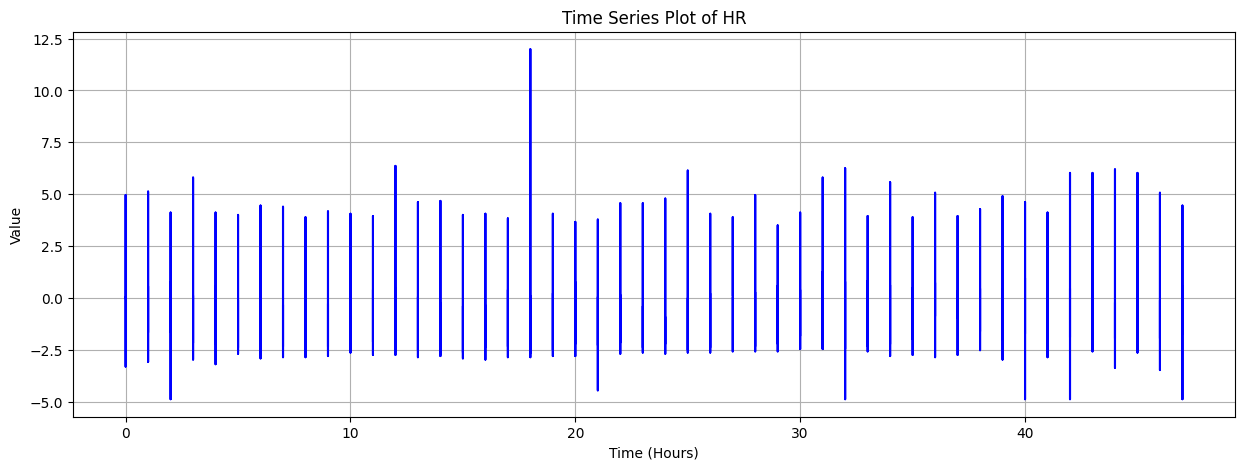

In [11]:
def plot_time_series(loader, attribute_index):
    all_times = []
    all_values = []

    # Loop through each batch in the loader
    for batch in loader:
        # Get the observed data and time points
        observed_data = batch['observed_data']
        timepoints = batch['timepoints']
        
        # Extract values for the specific attribute
        values = observed_data[:, :, attribute_index]
        
        # Append data
        all_times.append(timepoints.numpy())  # Convert to numpy array if needed
        all_values.append(values.numpy())  # Convert to numpy array if needed

    # Concatenate all collected data
    times = np.concatenate(all_times)
    values = np.concatenate(all_values)
    
    # Plot the time series
    plt.figure(figsize=(15, 5))
    plt.plot(times, values, label=f'Time Series of {attributes[attribute_index]}', color='blue')
    plt.title(f'Time Series Plot of {attributes[attribute_index]}')
    plt.xlabel('Time (Hours)')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

plot_time_series(train_loader, 1)  # for HR 

#### Overview of the Plot
- **X-axis (Time in Hours)**: Represents the time from 0 to 48 hours, showing the progression of hours in a two-day period.
- **Y-axis (Value)**: Displays the HR values. The scale ranges from approximately -5 to 12.5, indicating the observed heart rate values over time.

#### Analysis of the Plot
- **Variability**: The plot shows significant variability in HR values throughout the 48-hour period. The HR values fluctuate frequently, suggesting periods of varying cardiac activity or measurement artifacts.
- **Outliers**: There are several spikes where the HR values rise sharply above the general level or drop below it. These could represent moments of stress, physical activity, or possibly errors in data collection or anomalies in measurement.
- **General Observations**: Most HR values seem to fluctuate around a central band between 0 and 5, with frequent deviations above and below this range.



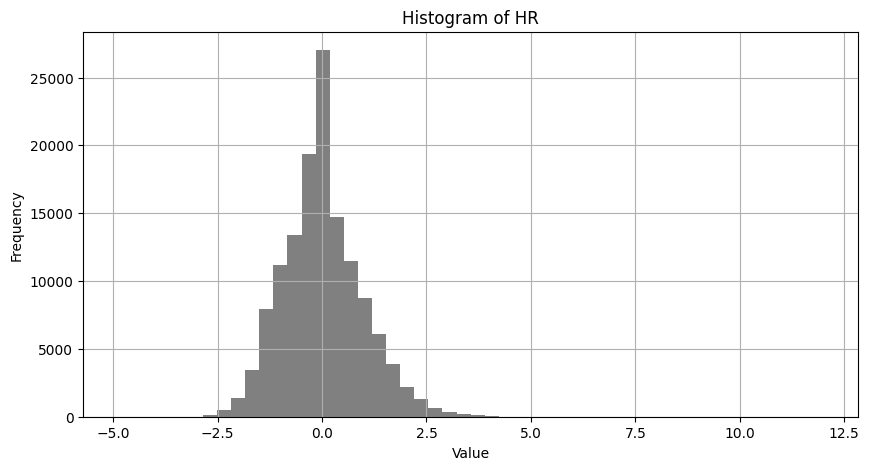

In [12]:
def plot_histogram(loader, attribute_index):
    all_values = []

    for batch in loader:
        all_values.append(batch["observed_data"][:, :, attribute_index])

    values = np.concatenate(all_values, axis=0).flatten()

    plt.figure(figsize=(10, 5))
    plt.hist(values, bins=50, color="gray")
    plt.title(f"Histogram of {attributes[attribute_index]}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


# Example call
plot_histogram(train_loader, 1)  # Adjust the attribute index as needed

#### Overview & Interpretation of the Histogram
- **X-axis (Value)**: Represents the HR (Heart Rate) values.
- **Y-axis (Frequency)**: Indicates the number of occurrences for each HR value range, illustrating how frequently each range appears in the dataset.
- **Central Peak**: The highest peak around the zero value suggests that the most common HR values are centered around this point.
- **Symmetry and Shape**: The histogram appears roughly symmetric about the central peak, implying a normal distribution of HR values. This symmetry suggests that values of HR equally deviate around a central value with no significant skewness toward high or low extremes.
- **Spread**: The spread from approximately -5 to 5 covers the bulk of HR values, indicating the range within which most HR measurements fall.

#### Implications in a Broader Context
- **Normal Distribution**: The normal-like distribution of HR values might indicate typical physiological behavior if HR indeed refers to heart rate, with most measurements clustering around a typical resting or active state, depending on the population studied.
- **Potential Outliers**: The presence of values beyond this range, especially toward 10 or -5, although less frequent, could indicate moments of extreme physiological activity or measurement errors, which might warrant further investigation.

#### Use in Time Series Analysis
- **Identifying Anomalies**: The tails of the distribution could help identify anomalous times where HR was exceptionally high or low.
- **Statistical Modeling**: Understanding the distribution helps in modeling HR behavior over time, particularly if applying statistical or machine learning models that assume a normal distribution of the input data.


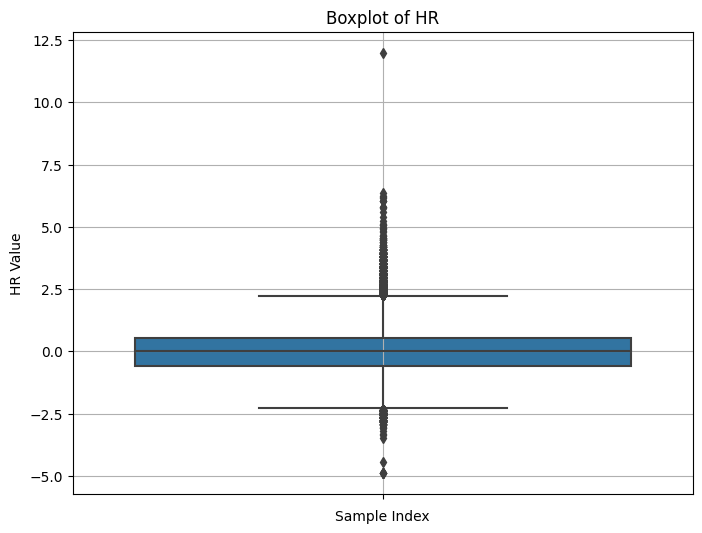

In [13]:
def plot_boxplot(loader, attribute_index):
    all_values = []

    for batch in loader:
        all_values.append(batch["observed_data"][:, :, attribute_index])

    values = np.concatenate(all_values, axis=0).flatten()

    plt.figure(figsize=(8, 6))
    sns.boxplot(y=values)
    plt.title(f"Boxplot of {attributes[attribute_index]}")
    plt.xlabel("Sample Index")
    plt.ylabel(f"{attributes[attribute_index]} Value")
    plt.grid(True)
    plt.show()

# Example call
plot_boxplot(train_loader, 1)  

#### Components of the Boxplot
- **Central Box**: Represents the interquartile range (IQR), containing the middle 50% of the data, with the bottom (Q1) and top (Q3) of the box indicating the first and third quartiles.
- **Median Line**: The line within the box shows the median of the data, providing a central value.
- **Whiskers**: These extend from the box to cover 1.5 times the IQR, defining the "normal" range of data, beyond which any points are considered outliers.
- **Outliers**: Points plotted beyond the whiskers are outliers, indicating unusual data points that are significantly higher or lower than the rest.

#### Interpretation in Time Series Context
- **Variability**: The spread of the box and the length of the whiskers illustrate the variability in HR values, which could suggest frequent fluctuations.
- **Central Tendency**: The median provides insight into the typical HR value around which data points tend to concentrate.
- **Outliers and Spikes**: Outliers may signal unusual events or errors in data collection, which are crucial in time series analysis to understand transient or abnormal behaviors.

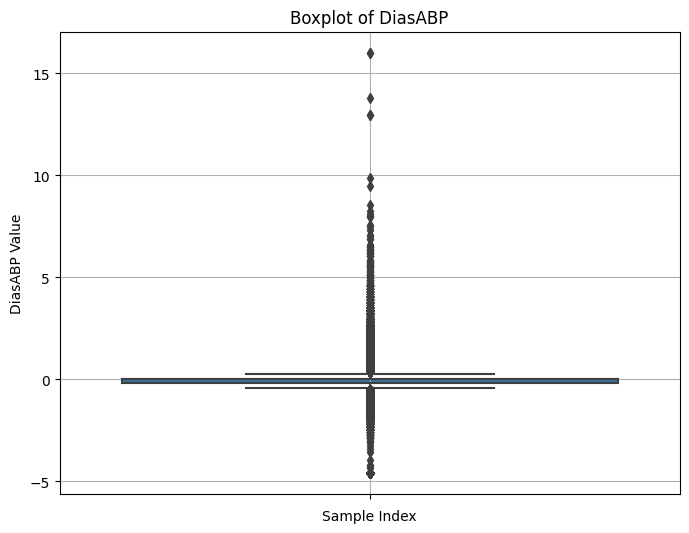

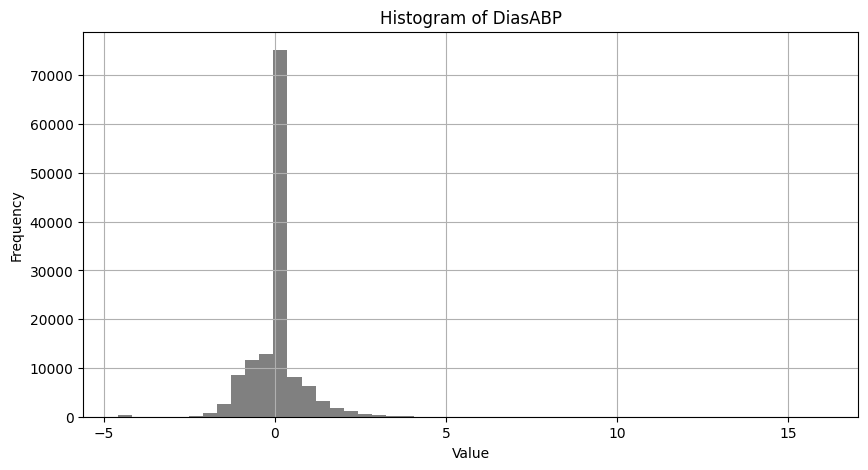

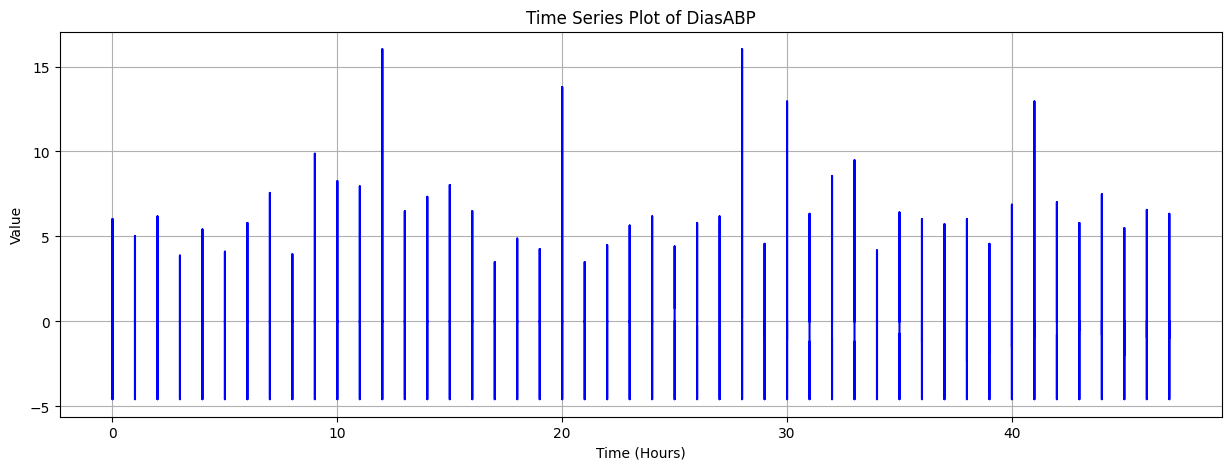

In [14]:
# Plots for the first attribute (DiasABP)
plot_boxplot(train_loader, 0)
plot_histogram(train_loader, 0)
plot_time_series(train_loader, 0)

## Model Training

### Output Folder Setup
Before training the model, an output directory is created to store training artifacts such as model checkpoints, logs, and output files. The directory name includes a timestamp to ensure uniqueness and to help track experiments based on the date and time they were performed.

- **Directory Naming**: The folder is named using the current date and time, which helps in organizing and retrieving model training sessions based on when they were conducted.
- **Creation**: The directory is created on the file system, ensuring it exists before any training outputs are written to it. This prevents errors related to file writing during model training.

### Model Training Process
The model is trained using the specified configurations, data loaders, and the path to the output directory. The training function is designed to handle both the training and validation phases within each epoch, allowing for a comprehensive assessment of model performance over time.

- **Training Function**: Takes the model, training configurations, and data loaders as inputs. Additionally, it accepts the path to the output folder where the training results are stored.
- **Validation Data**: Optionally, a validation loader can be passed to periodically evaluate model performance on a separate validation set during the training process.

### Execution
Upon execution, the training process iteratively updates the model weights based on the loss computed from the training data. It also evaluates the model on the validation set, if provided, to monitor its performance on unseen data. Results and model states are saved in the designated output directory, facilitating post-training evaluations and model deployment.

### Loss Function
The loss function employed in the CSDI model is designed to optimize the model's ability to denoise data:
- **Denoising Loss**: During training, the model calculates the loss as the squared difference between the actual noise added to the data in the forward process and the noise predicted by the model during the reverse diffusion process. This loss function is key to training the model to accurately reverse the noise addition, effectively reconstructing the original data from its noisy version.

### Metrics
1. **Mean Absolute Error (MAE)**: This metric measures the average magnitude of errors in a set of predictions, without considering their direction. It's a linear score that averages the absolute differences between predicted and actual values, providing a straightforward interpretation of prediction accuracy.
2. **Continuous Ranked Probability Score (CRPS)**: CRPS is used to assess the accuracy of probabilistic predictions. It measures the difference between the predicted cumulative distribution function and the empirical distribution function of the observed data. This score is particularly useful for evaluating the performance of models that generate probabilistic or distributional forecasts.


In [15]:
# Set up output folder
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
foldername = f"./save/physio_{current_time}/"
os.makedirs(foldername, exist_ok=True)

In [16]:
# Train the model
train(
    model,
    config["train"],
    train_loader,
    valid_loader=valid_loader,
    foldername=foldername,
)

100%|██████████| 26/26 [00:53<00:00,  2.07s/it, valid_avg_epoch_loss=0.205, epoch=19]



 best loss is updated to  0.20525106157247835 at 19


100%|██████████| 26/26 [00:52<00:00,  2.01s/it, valid_avg_epoch_loss=0.204, epoch=39]



 best loss is updated to  0.20417219973527467 at 39


100%|██████████| 26/26 [00:52<00:00,  2.02s/it, valid_avg_epoch_loss=0.193, epoch=59]



 best loss is updated to  0.19322149283610857 at 59


100%|██████████| 26/26 [00:52<00:00,  2.03s/it, valid_avg_epoch_loss=0.191, epoch=79]



 best loss is updated to  0.19053313308037245 at 79


100%|██████████| 26/26 [00:52<00:00,  2.01s/it, valid_avg_epoch_loss=0.186, epoch=99]



 best loss is updated to  0.1858809945675043 at 99


100%|██████████| 26/26 [00:52<00:00,  2.01s/it, valid_avg_epoch_loss=0.183, epoch=119]



 best loss is updated to  0.1834667668892787 at 119


100%|██████████| 26/26 [00:52<00:00,  2.01s/it, valid_avg_epoch_loss=0.175, epoch=159]



 best loss is updated to  0.1751347350386473 at 159


100%|██████████| 26/26 [00:52<00:00,  2.01s/it, valid_avg_epoch_loss=0.174, epoch=179]



 best loss is updated to  0.1743103047976127 at 179


100%|██████████| 26/26 [00:52<00:00,  2.02s/it, valid_avg_epoch_loss=0.175, epoch=199]


## Loading a Pretrained Model

### Function for Loading Model State
To enhance or expedite the training process, or for evaluation purposes, you may start with a model that has already been trained. The function `load_pretrained_model` facilitates the loading of these pretrained weights into an existing model architecture.

- **Parameters**:
  - `model`: The model instance into which the pretrained weights will be loaded.
  - `modelfolder`: The subdirectory under `./save/` where the pretrained model is stored, defaulting to `pretrained`.
  - `device`: The computing device (CPU or GPU) where the model will be loaded. This ensures that the model is compatible with the hardware used for subsequent operations.

### Execution
The function constructs the full path to the pretrained model's state dictionary file (`model.pth`) using the specified `modelfolder`. It then loads this state dictionary into the model, ensuring that all model parameters are updated accordingly.

- **Model Compatibility**:
  - It is crucial that the model architecture into which the weights are being loaded matches the architecture of the model when it was saved. Incompatibility in architectures will lead to errors during the loading process.

### Usage
To utilize a pretrained model, simply pass your initialized but untrained model to the `load_pretrained_model` function. This setup allows you to leverage previously learned patterns, potentially reducing training time and improving model robustness from the outset.

In [25]:
def load_pretrained_model(model, modelfolder="pretrained", device=device):
    #physio_20240731_012916
    model_path = f"./save/{modelfolder}/model.pth"
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model

In [26]:
# Load pre-trained model
pretrained_model = load_pretrained_model(model)

## Model Evaluation

### Evaluation Parameters Configuration
Prior to evaluating the models, several key parameters are established:
- **`nsample`**: Specifies the number of samples to generate during model evaluation, set to 100 for comprehensive testing.
- **`scaler`** and **`mean_scaler`**: Define scaling factors for the data. These parameters adjust the data normalization during the evaluation to match the conditions used during model training.

### Update Data Loader
To accurately reflect real-world scenarios where data may be incomplete:
- **`missing_ratio`**: Set to 0.1 to simulate a 10% missing data scenario during evaluation. This helps in assessing the model's robustness and performance under conditions of incomplete data.

### Data Loader Configuration
- The test data loader is updated to include the new missing ratio, ensuring that the evaluation tests the model's ability to handle and impute missing data effectively.

### Model Evaluation
- **Current Model Evaluation**: The initially trained model is evaluated using the updated `test_loader`. This step is crucial for understanding the baseline performance of the model on the test set.
- **Pre-trained Model Evaluation**: Additionally, a pre-trained model is evaluated under the same conditions. This is particularly useful for comparing the effectiveness of pre-training and fine-tuning strategies on model performance.

### Execution
Both the current and pre-trained models are evaluated with the specified number of samples and scaling parameters. The results are stored in a designated folder, facilitating subsequent analysis and comparison:

In [22]:
# Set evaluation parameters
nsample = 100  # number of samples for evaluation
scaler = 1  # scaler for the data
mean_scaler = 0  # mean scaler for the data
missing_ratio = 0.1  # test missing ratio

# Update test_loader with new missing ratio
_, _, test_loader = get_dataloader(
    seed=1,
    nfold=0,
    batch_size=config["train"]["batch_size"],
    missing_ratio=missing_ratio,
)

In [ ]:
# Evaluate the current model with updated test_loader
evaluate(
    model,
    test_loader,
    nsample=nsample,
    scaler=scaler,
    mean_scaler=mean_scaler,
    foldername=foldername,
)

In [ ]:
# Evaluate the pre-trained model with the same parameters
evaluate(
    pretrained_model,
    test_loader,
    nsample=nsample,
    scaler=scaler,
    mean_scaler=mean_scaler,
    foldername=foldername,
)

 52%|█████▏    | 26/50 [1:27:05<1:20:41, 201.73s/it, rmse_total=0.448, mae_total=0.21, batch_no=26] 

### References
- Tashiro, Yusuke, et al. "CSDI: Conditional Score-based Diffusion Models for Probabilistic Time Series Imputation." *Advances in Neural Information Processing Systems*. 2021. [GitHub Repository](https://github.com/ermongroup/CSDI)
